In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/data/FloodNet/'

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
from PIL import Image # Import the Pillow library
from IPython.display import display
from tqdm import tqdm # Import tqdm for progress bars
import torchvision.transforms as transforms # Import transforms from torchvision

# Make sure Pillow is installed
try:
    from PIL import Image
except ImportError:
    print("Pillow not installed. Installing now...")
    !pip install Pillow
    from PIL import Image

In [ ]:
import json
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import os # Ensure os is imported

# Define image transforms
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Holds processed data
dataset = []

# Folder info
root_dir = "/content/drive/MyDrive/data/FloodNet/"
splits = ["train", "test", "validation"]

for split in splits:
    img_dir = os.path.join(root_dir, split, "img")
    ann_dir = os.path.join(root_dir, split, "ann")

    if os.path.exists(img_dir):
        # Iterate through image files with a progress bar
        for filename in tqdm(os.listdir(img_dir), desc=f"Processing {split}"):
            if filename.endswith('.jpg'):
                img_path = os.path.join(img_dir, filename)
                # Annotation filename is usually the same as image filename + .json
                ann_path = os.path.join(ann_dir, filename + ".json")

                try:
                    # Load image and get original dimensions
                    image = Image.open(img_path).convert("RGB")
                    original_width, original_height = image.size # Get original dimensions

                    # Apply image transform (resizing happens here)
                    image = image_transform(image)

                    # Load annotation
                    label_data = []
                    if os.path.exists(ann_path):
                        try:
                            with open(ann_path, 'r') as f:
                                ann = json.load(f)

                            if "objects" in ann and isinstance(ann["objects"], list):
                                for obj in ann["objects"]:
                                    label = obj.get("classTitle", "unknown")
                                    points = obj.get("points", {}).get("exterior", [])

                                    scaled_points = []
                                    normalized_points = []

                                    for x, y in points:
                                      # Scaling to resized image (224x224)
                                      width_scale = 224 / original_width
                                      height_scale = 224 / original_height
                                      scaled_x = int(x * width_scale)
                                      scaled_y = int(y * height_scale)
                                      scaled_points.append([scaled_x, scaled_y])

                                      # Normalizing relative to original image size (0–1)
                                      norm_x = x / original_width
                                      norm_y = y / original_height
                                      normalized_points.append([norm_x, norm_y])

                                    # Store both scaled and normalized points if needed later
                                    label_data.append({
                                        "label": label,
                                        "points_scaled": scaled_points,
                                        "points_normalized": normalized_points # Keep normalized if needed
                                    })

                            else:
                                print(f"Warning: 'objects' key not found or not a list in {ann_path}")
                                label_data = [{"label": "unlabeled", "points_scaled": [], "points_normalized": []}] # Update structure

                        except json.JSONDecodeError as e:
                            print(f"Error decoding JSON in {ann_path}: {e}")
                            label_data = [{"label": "unlabeled", "points_scaled": [], "points_normalized": []}] # Update structure
                        except Exception as e:
                            print(f"Error loading annotation from {ann_path}: {e}")
                            label_data = [{"label": "unlabeled", "points_scaled": [], "points_normalized": []}] # Update structure
                    else:
                        label_data = [{"label": "unlabeled", "points_scaled": [], "points_normalized": []}] # Update structure

                    # Append the image (as tensor) and its annotation data to the dataset
                    dataset.append((image, label_data))

                except Exception as e:
                    print(f"Error processing image {filename} or associated data: {e}")



Processing validation: 100%|██████████| 450/450 [04:51<00:00,  1.54it/s]


In [ ]:
# You can still run your check for annotated vs unlabeled images after this
annotated = 0
unlabeled = 0

for image, annotations in dataset:
    # Check if any annotation for this image has a label other than 'unlabeled'
    is_annotated = any(item.get('label') != 'unlabeled' for item in annotations) # Use .get for safety
    if is_annotated:
        annotated += 1
    else:
        unlabeled += 1

print(f"Annotated images: {annotated}")
print(f"Unlabeled images: {unlabeled}")
print(f"Total items in dataset: {len(dataset)}")

Annotated images: 398
Unlabeled images: 1945
Total items in dataset: 2343


In [ ]:
print(f"Found annotation in {ann_path}: {label}, points: {scaled_points}")


Found annotation in /content/drive/MyDrive/data/FloodNet/validation/ann/8273.jpg.json: grass, points: []


In [ ]:
for i in range(min(5, len(dataset))):
    print(f"Item {i}: Image shape - {dataset[i][0].shape}, Annotations - {dataset[i][1]}")


Item 0: Image shape - torch.Size([3, 224, 224]), Annotations - []
Item 1: Image shape - torch.Size([3, 224, 224]), Annotations - []
Item 2: Image shape - torch.Size([3, 224, 224]), Annotations - []
Item 3: Image shape - torch.Size([3, 224, 224]), Annotations - []
Item 4: Image shape - torch.Size([3, 224, 224]), Annotations - []


In [ ]:
for i in range(min(5, len(dataset))):
    img, anns = dataset[i]
    print(f"Item {i}: Image shape - {img.shape}")
    for ann in anns:
        print(f"  - Label: {ann['label']}, Scaled Points: {ann['points_scaled']}")


Item 0: Image shape - torch.Size([3, 224, 224])
Item 1: Image shape - torch.Size([3, 224, 224])
Item 2: Image shape - torch.Size([3, 224, 224])
Item 3: Image shape - torch.Size([3, 224, 224])
Item 4: Image shape - torch.Size([3, 224, 224])


Visualizing Sample 1 with 0 annotations:


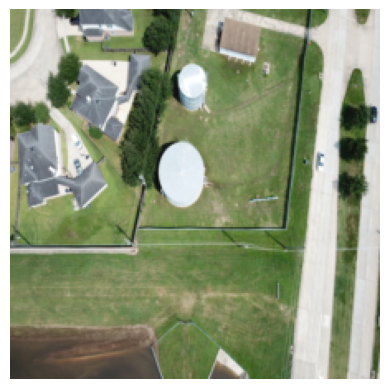

Visualizing Sample 2 with 0 annotations:


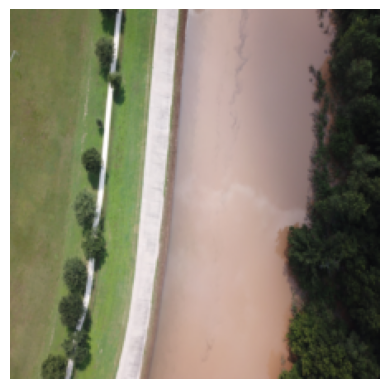

Visualizing Sample 3 with 0 annotations:


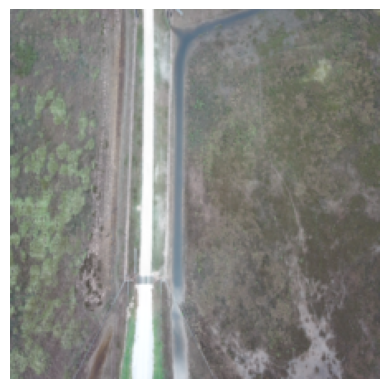

Visualizing Sample 4 with 0 annotations:


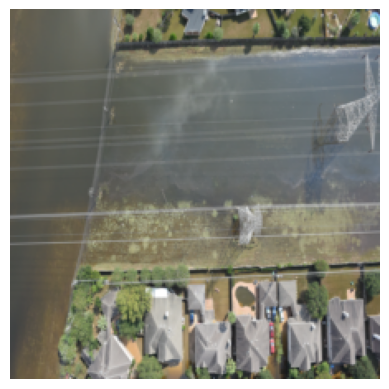

Visualizing Sample 5 with 0 annotations:


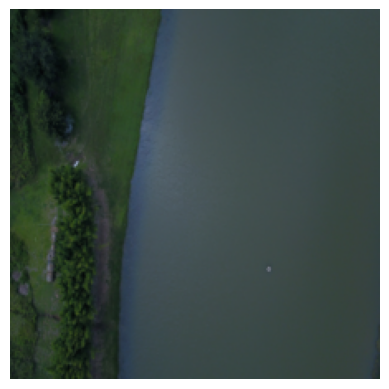

In [ ]:
import matplotlib.patches as patches
import torch

# Function to visualize an image with annotations
def visualize_sample(image_tensor, annotations):
    # Convert tensor to PIL image for plotting
    # Denormalize the image if you normalized it
    # Assuming normalization was done with mean/std [0.5, 0.5, 0.5]
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    image_tensor = image_tensor * std + mean
    image_np = image_tensor.permute(1, 2, 0).numpy() # Convert C H W to H W C for matplotlib

    fig, ax = plt.subplots(1)
    ax.imshow(image_np)

    for ann in annotations:
        label = ann.get('label', 'unlabeled')
        # Use scaled points for visualization on the resized image
        points = ann.get('points_scaled', [])

        if points:
            # You have polygon points. You can draw a polygon or a bounding box around it.
            # For simplicity, let's draw a bounding box around the min/max points.
            x_coords = [p[0] for p in points]
            y_coords = [p[1] for p in points]

            if x_coords and y_coords:
                x_min, x_max = min(x_coords), max(x_coords)
                y_min, y_max = min(y_coords), max(y_coords)

                # Create a Rectangle patch
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                         linewidth=1, edgecolor='r', facecolor='none')

                # Add the patch to the Axes
                ax.add_patch(rect)

                # Add label
                plt.text(x_min, y_min - 5, label, color='red', fontsize=10)
        else:
             # Handle cases with no points if needed (e.g., print a message)
             pass

    plt.axis('off') # Hide axes
    plt.show()

# Visualize the first few samples from your dataset
num_samples_to_visualize = 5

for i in range(min(num_samples_to_visualize, len(dataset))):
    image, annotations = dataset[i]
    print(f"Visualizing Sample {i+1} with {len(annotations)} annotations:")
    visualize_sample(image, annotations)

# Model CNN


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Calculate the output size of the last pooling layer
        # Input image size is 224x224. After 3 conv/pool layers:
        # 224 -> 112 -> 56 -> 28
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes) # Output for classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28) # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # No activation on the output layer for classification loss
        return x

# Determine the number of unique classes from your dataset
# You'll need to extract the unique class labels from your annotations
# This is a placeholder, replace with actual logic to get num_classes
all_labels = set()
for _, annotations in dataset:
    for ann in annotations:
        all_labels.add(ann.get('label', 'unlabeled'))

# Remove 'unlabeled' if you don't want it as a separate class, or keep it
if 'unlabeled' in all_labels and len(all_labels) > 1:
    all_labels.remove('unlabeled') # Example: if 'unlabeled' isn't a class you want to predict
elif 'unlabeled' in all_labels and len(all_labels) == 1:
    # If only 'unlabeled' exists, handle this case - maybe skip model definition or set num_classes to 1?
    print("Warning: Only 'unlabeled' class found. Model definition might not be suitable.")
    num_classes = 1 # Or handle as an error
else:
    pass # Proceed as normal

num_classes = len(all_labels) if len(all_labels) > 0 else 1 # Ensure num_classes is at least 1

print(f"Detected classes: {all_labels}")
print(f"Number of classes for the model: {num_classes}")

# Instantiate the model
# Ensure num_classes is defined based on your annotation labels
# You might need to map label strings to integer indices later
model = CNNModel(num_classes=num_classes)
model


Detected classes: {'background', 'water', 'grass', 'building non-flooded', 'vehicle', 'tree', 'road non-flooded', 'pool', 'road flooded', 'building flooded'}
Number of classes for the model: 10


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
import matplotlib.pyplot as plt

# Map labels to integers (simple binary case for the CNN example)
label_map = {'unlabeled': 0}
current_label_idx = 1 # Start indexing from 1 for actual object classes

# You might need a more sophisticated mapping if you want to classify into specific object types
# For this CNN , we'll just do binary: has_object vs no_object
class_to_idx = {'no_object': 0, 'has_object': 1}


processed_cnn_dataset = []
for image, annotations in dataset:
    # Determine the image-level label for CNN classification
    has_object = any(ann.get('label') != 'unlabeled' for ann in annotations)
    image_label_idx = class_to_idx['has_object'] if has_object else class_to_idx['no_object']

    processed_cnn_dataset.append((image, image_label_idx))

print(f"Prepared dataset for CNN classification with {len(processed_cnn_dataset)} samples.")
# Check distribution
num_has_object = sum(1 for _, label_idx in processed_cnn_dataset if label_idx == class_to_idx['has_object'])
num_no_object = sum(1 for _, label_idx in processed_cnn_dataset if label_idx == class_to_idx['no_object'])
print(f"Samples with objects: {num_has_object}")
print(f"Samples without objects: {num_no_object}")

# Let's create new lists based on the original splits
cnn_train_dataset = []
cnn_val_dataset = []
cnn_test_dataset = []

# Re-process data to maintain original splits
processed_cnn_split_datasets = {
    'train': [],
    'validation': [],
    'test': []
}

for split in splits:
    img_dir = os.path.join(root_dir, split, "img")
    ann_dir = os.path.join(root_dir, split, "ann")

    if os.path.exists(img_dir):
        for filename in tqdm(os.listdir(img_dir), desc=f"Processing {split} for CNN split"):
            if filename.endswith('.jpg'):
                img_path = os.path.join(img_dir, filename)
                ann_path = os.path.join(ann_dir, filename + ".json")

                try:
                    image = Image.open(img_path).convert("RGB")
                    original_width, original_height = image.size
                    image_tensor = image_transform(image)

                    # Load annotation and determine image-level label
                    has_object = False
                    if os.path.exists(ann_path):
                         try:
                            with open(ann_path, 'r') as f:
                                ann = json.load(f)
                            if "objects" in ann and isinstance(ann["objects"], list):
                                # Check if any object has a label other than 'unlabeled'
                                has_object = any(obj.get("classTitle") != "unlabeled" for obj in ann["objects"])
                         except Exception as e:
                            print(f"Error processing annotation {ann_path}: {e}")

                    image_label_idx = class_to_idx['has_object'] if has_object else class_to_idx['no_object']

                    processed_cnn_split_datasets[split].append((image_tensor, image_label_idx))

                except Exception as e:
                     print(f"Error processing image {filename} for split {split}: {e}")


cnn_train_dataset = processed_cnn_split_datasets['train']
cnn_val_dataset = processed_cnn_split_datasets['validation']
cnn_test_dataset = processed_cnn_split_datasets['test']

print(f"CNN Train samples: {len(cnn_train_dataset)}")
print(f"CNN Validation samples: {len(cnn_val_dataset)}")
print(f"CNN Test samples: {len(cnn_test_dataset)}")


# Create DataLoaders
from torch.utils.data import DataLoader

batch_size = 32

cnn_train_loader = DataLoader(cnn_train_dataset, batch_size=batch_size, shuffle=True)
cnn_val_loader = DataLoader(cnn_val_dataset, batch_size=batch_size, shuffle=False)
cnn_test_loader = DataLoader(cnn_test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate the CNN model for binary classification
# num_classes will be 2 ('no_object', 'has_object')
cnn_num_classes = len(class_to_idx)
cnn_model = CNNModel(num_classes=cnn_num_classes)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss() # Appropriate for classification
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

print(f"Using device: {device}")

# Training loop for CNN
num_epochs = 10 # Define number of training epochs

print("Starting CNN Training...")
for epoch in range(num_epochs):
    cnn_model.train() # Set model to training mode
    running_loss = 0.0
    for images, labels in tqdm(cnn_train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(cnn_train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Validation loop
    cnn_model.eval() # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(cnn_val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)"):
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(cnn_val_dataset)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")

print("Finished CNN Training.")

# Evaluate the CNN model on the test set
print("Evaluating CNN on Test Set...")
cnn_model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(cnn_test_loader, desc="Evaluating CNN Test"):
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(cnn_test_dataset)
test_accuracy = 100 * correct / total
print(f"CNN Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")



Prepared dataset for CNN classification with 2343 samples.
Samples with objects: 398
Samples without objects: 1945


Processing validation for CNN split: 100%|██████████| 450/450 [01:37<00:00,  4.60it/s]


CNN Train samples: 1445
CNN Validation samples: 450
CNN Test samples: 448
Using device: cuda
Starting CNN Training...


Epoch 1/10 (Train): 100%|██████████| 46/46 [00:04<00:00,  9.65it/s]


Epoch [1/10], Loss: 0.7731


Epoch 1/10 (Validation): 100%|██████████| 15/15 [00:00<00:00, 27.42it/s]


Validation Loss: 0.3825, Accuracy: 100.00%


Epoch 2/10 (Train): 100%|██████████| 46/46 [00:03<00:00, 13.84it/s]


Epoch [2/10], Loss: 0.5937


Epoch 2/10 (Validation): 100%|██████████| 15/15 [00:00<00:00, 39.79it/s]


Validation Loss: 0.3867, Accuracy: 100.00%


Epoch 3/10 (Train): 100%|██████████| 46/46 [00:03<00:00, 14.11it/s]


Epoch [3/10], Loss: 0.5897


Epoch 3/10 (Validation): 100%|██████████| 15/15 [00:00<00:00, 38.96it/s]


Validation Loss: 0.3351, Accuracy: 100.00%


Epoch 4/10 (Train): 100%|██████████| 46/46 [00:03<00:00, 13.98it/s]


Epoch [4/10], Loss: 0.5922


Epoch 4/10 (Validation): 100%|██████████| 15/15 [00:00<00:00, 39.91it/s]


Validation Loss: 0.4266, Accuracy: 100.00%


Epoch 5/10 (Train): 100%|██████████| 46/46 [00:03<00:00, 13.73it/s]


Epoch [5/10], Loss: 0.5819


Epoch 5/10 (Validation): 100%|██████████| 15/15 [00:00<00:00, 38.15it/s]


Validation Loss: 0.2475, Accuracy: 100.00%


Epoch 6/10 (Train): 100%|██████████| 46/46 [00:03<00:00, 14.12it/s]


Epoch [6/10], Loss: 0.5731


Epoch 6/10 (Validation): 100%|██████████| 15/15 [00:00<00:00, 38.47it/s]


Validation Loss: 0.4415, Accuracy: 92.67%


Epoch 7/10 (Train): 100%|██████████| 46/46 [00:03<00:00, 13.99it/s]


Epoch [7/10], Loss: 0.5532


Epoch 7/10 (Validation): 100%|██████████| 15/15 [00:00<00:00, 39.24it/s]


Validation Loss: 0.1458, Accuracy: 99.78%


Epoch 8/10 (Train): 100%|██████████| 46/46 [00:03<00:00, 13.80it/s]


Epoch [8/10], Loss: 0.5557


Epoch 8/10 (Validation): 100%|██████████| 15/15 [00:00<00:00, 38.43it/s]


Validation Loss: 0.4115, Accuracy: 91.33%


Epoch 9/10 (Train): 100%|██████████| 46/46 [00:03<00:00, 13.95it/s]


Epoch [9/10], Loss: 0.5204


Epoch 9/10 (Validation): 100%|██████████| 15/15 [00:00<00:00, 38.18it/s]


Validation Loss: 0.3909, Accuracy: 86.44%


Epoch 10/10 (Train): 100%|██████████| 46/46 [00:03<00:00, 14.00it/s]


Epoch [10/10], Loss: 0.4838


Epoch 10/10 (Validation): 100%|██████████| 15/15 [00:00<00:00, 39.37it/s]


Validation Loss: 0.3632, Accuracy: 87.56%
Finished CNN Training.
Evaluating CNN on Test Set...


Evaluating CNN Test: 100%|██████████| 14/14 [00:00<00:00, 35.07it/s]

CNN Test Loss: 0.3252, Test Accuracy: 92.41%


# Model U-Net

In [ ]:
# --- U-Net Model for Semantic Segmentation ---
# U-Net is used for semantic segmentation, predicting a class for each pixel.
# For this, we need to generate segmentation masks from your polygon annotations.
# This is a more complex data preparation step.
# Each image will need a corresponding ground truth mask tensor of size [H, W]
# where each pixel value is the class index (e.g., 0 for background, 1 for flood, etc.)

# First, define the class mapping for segmentation
# You need to decide which of your object classes you want to segment.
# Let's create a mapping including 'background'.
segmentation_classes = sorted(list(all_labels)) # Sort to ensure consistent indexing
if 'unlabeled' in segmentation_classes:
    segmentation_classes.remove('unlabeled') # Remove unlabeled as a segmentable class
segmentation_classes.insert(0, 'background') # Add background as class 0

seg_class_to_idx = {cls: i for i, cls in enumerate(segmentation_classes)}
seg_idx_to_class = {i: cls for cls, i in seg_class_to_idx.items()}

print(f"\nSegmentation Classes: {segmentation_classes}")
print(f"Segmentation Class to Index mapping: {seg_class_to_idx}")
seg_num_classes = len(segmentation_classes)

# Data Preparation for U-Net: Creating Masks
processed_unet_split_datasets = {
    'train': [],
    'validation': [],
    'test': []
}

# Helper function to create a mask from annotations
def create_segmentation_mask(annotations, original_width, original_height, resized_width, resized_height, class_to_idx_map):
    # Initialize mask with background class (0)
    mask = torch.zeros((resized_height, resized_width), dtype=torch.long)

    # Pillow's ImageDraw can be used to draw polygons onto an image/mask
    try:
        from PIL import ImageDraw
    except ImportError:
         print("Pillow's ImageDraw not found. Ensure Pillow is installed.")
         return mask # Return empty mask if ImageDraw is not available

    mask_img = Image.new('L', (resized_width, resized_height), 0) # 'L' mode for single channel (grayscale)
    draw = ImageDraw.Draw(mask_img)

    for ann in annotations:
        label = ann.get('label', 'unlabeled')
        # Use scaled points (already resized to 224x224)
        scaled_points = ann.get('points_scaled', [])

        if label != 'unlabeled' and label in class_to_idx_map and scaled_points:
            class_idx = class_to_idx_map[label]
            # Flatten the list of points for ImageDraw
            flattened_points = [(p[0], p[1]) for p in scaled_points]

            if len(flattened_points) >= 3: # Need at least 3 points for a polygon
                # Draw the polygon on the mask image with the corresponding class index value
                draw.polygon(flattened_points, fill=class_idx)
            elif len(flattened_points) == 1: # Handle single points if necessary (e.g., draw a small circle)
                 # This depends on how you want to represent points in a mask
                 pass
            elif len(flattened_points) == 2: # Handle lines if necessary
                 pass

    # Convert the Pillow mask image to a PyTorch tensor
    mask_tensor = torch.tensor(list(mask_img.getdata()), dtype=torch.long).view(resized_height, resized_width)

    return mask_tensor


# Reprocess data to create image-mask pairs for U-Net
for split in splits:
    img_dir = os.path.join(root_dir, split, "img")
    ann_dir = os.path.join(root_dir, split, "ann")

    if os.path.exists(img_dir):
        for filename in tqdm(os.listdir(img_dir), desc=f"Processing {split} for U-Net split"):
            if filename.endswith('.jpg'):
                img_path = os.path.join(img_dir, filename)
                ann_path = os.path.join(ann_dir, filename + ".json")

                try:
                    image = Image.open(img_path).convert("RGB")
                    original_width, original_height = image.size

                    # Apply image transform (resizing and normalization)
                    image_tensor = image_transform(image)

                    # Load annotations and create mask
                    annotations = []
                    if os.path.exists(ann_path):
                        try:
                            with open(ann_path, 'r') as f:
                                ann = json.load(f)
                            if "objects" in ann and isinstance(ann["objects"], list):
                                for obj in ann["objects"]:
                                    label = obj.get("classTitle", "unlabeled")
                                    points = obj.get("points", {}).get("exterior", [])

                                    scaled_points = []
                                    # Scale points to the target U-Net input size (224x224)
                                    resized_width, resized_height = 224, 224 # Target size from transforms
                                    width_scale = resized_width / original_width
                                    height_scale = resized_height / original_height
                                    for x, y in points:
                                      scaled_x = int(x * width_scale)
                                      scaled_y = int(y * height_scale)
                                      scaled_points.append([scaled_x, scaled_y])

                                    annotations.append({
                                        "label": label,
                                        "points_scaled": scaled_points # Use scaled points for mask generation
                                    })
                        except Exception as e:
                            print(f"Error processing annotation {ann_path}: {e}")

                    # Create the segmentation mask
                    # Pass original dimensions and target resized dimensions
                    mask_tensor = create_segmentation_mask(annotations, original_width, original_height, 224, 224, seg_class_to_idx)

                    processed_unet_split_datasets[split].append((image_tensor, mask_tensor))

                except Exception as e:
                     print(f"Error processing image {filename} for split {split}: {e}")


unet_train_dataset = processed_unet_split_datasets['train']
unet_val_dataset = processed_unet_split_datasets['validation']
unet_test_dataset = processed_unet_split_datasets['test']

print(f"U-Net Train samples: {len(unet_train_dataset)}")
print(f"U-Net Validation samples: {len(unet_val_dataset)}")
print(f"U-Net Test samples: {len(unet_test_dataset)}")

# Create DataLoaders for U-Net
# For segmentation, masks are the labels
unet_train_loader = DataLoader(unet_train_dataset, batch_size=batch_size, shuffle=True)
unet_val_loader = DataLoader(unet_val_dataset, batch_size=batch_size, shuffle=False)
unet_test_loader = DataLoader(unet_test_dataset, batch_size=batch_size, shuffle=False)



# Define the U-Net model
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=seg_num_classes):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        def up_conv(in_c, out_c):
             return nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)


        # Contracting Path (Encoder)
        self.conv1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = conv_block(512, 1024)

        # Expanding Path (Decoder)
        self.upconv4 = up_conv(1024, 512)
        # The input to the conv block here is the concatenated tensor
        self.conv6 = conv_block(1024, 512) # 512 from upconv + 512 from conv4 skip

        self.upconv3 = up_conv(512, 256)
        self.conv7 = conv_block(512, 256) # 256 from upconv + 256 from conv3 skip

        self.upconv2 = up_conv(256, 128)
        self.conv8 = conv_block(256, 128) # 128 from upconv + 128 from conv2 skip

        self.upconv1 = up_conv(128, 64)
        self.conv9 = conv_block(128, 64) # 64 from upconv + 64 from conv1 skip

        # Output Layer
        self.outconv = nn.Conv2d(64, out_channels, kernel_size=1) # 1x1 conv to map to num_classes

    def forward(self, x):
        # Contracting Path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.conv3(p2)
        p3 = self.pool3(c3)

        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        c5 = self.conv5(p4)

        # Expanding Path
        up4 = self.upconv4(c5)
        # Skip connection + Upconvolution output
        # Need to ensure dimensions match for concatenation. Crop if necessary.
        # For this architecture, assuming input size is a multiple of 16 or 32,
        # dimensions should align.
        # If shapes don't match exactly (due to padding or stride issues),
        # you might need to crop one of the tensors.
        # Example cropping: up4 = F.interpolate(up4, size=c4.shape[2:], mode='bilinear', align_corners=False)
        merge4 = torch.cat([up4, c4], dim=1)
        c6 = self.conv6(merge4)

        up3 = self.upconv3(c6)
        merge3 = torch.cat([up3, c3], dim=1)
        c7 = self.conv7(merge3)

        up2 = self.upconv2(c7)
        merge2 = torch.cat([up2, c2], dim=1)
        c8 = self.conv8(merge2)

        up1 = self.upconv1(c8)
        merge1 = torch.cat([up1, c1], dim=1)
        c9 = self.conv9(merge1)

        # Output layer
        out = self.outconv(c9)

        return out

# Instantiate the U-Net model
unet_model = UNet(out_channels=seg_num_classes)
unet_model.to(device)

# Define Loss Function and Optimizer for U-Net
# CrossEntropyLoss is suitable for pixel-wise classification
criterion_unet = nn.CrossEntropyLoss()
optimizer_unet = torch.optim.Adam(unet_model.parameters(), lr=0.001)

# Training loop for U-Net
num_epochs_unet = 10 # Define number of training epochs for U-Net

print("\nStarting U-Net Training...")
for epoch in range(num_epochs_unet):
    unet_model.train() # Set model to training mode
    running_loss_unet = 0.0
    for images, masks in tqdm(unet_train_loader, desc=f"Epoch {epoch+1}/{num_epochs_unet} (U-Net Train)"):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = unet_model(images)
        # The outputs are logits (raw scores) for each class for each pixel
        # The masks are the ground truth class indices for each pixel

        # Calculate loss
        loss = criterion_unet(outputs, masks) # CrossEntropyLoss expects (N, C, H, W) logits and (N, H, W) masks

        # Backward and optimize
        optimizer_unet.zero_grad()
        loss.backward()
        optimizer_unet.step()

        running_loss_unet += loss.item() * images.size(0) # Sum up loss across batch

    epoch_loss_unet = running_loss_unet / len(unet_train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs_unet}], U-Net Loss: {epoch_loss_unet:.4f}")

    # Validation loop for U-Net
    unet_model.eval() # Set model to evaluation mode
    val_loss_unet = 0.0
    # You can also calculate segmentation metrics like IoU here, but for simplicity, we'll just show loss
    with torch.no_grad():
        for images, masks in tqdm(unet_val_loader, desc=f"Epoch {epoch+1}/{num_epochs_unet} (U-Net Validation)"):
            images, masks = images.to(device), masks.to(device)
            outputs = unet_model(images)
            loss = criterion_unet(outputs, masks)
            val_loss_unet += loss.item() * images.size(0)

    val_loss_unet /= len(unet_val_dataset)
    print(f"U-Net Validation Loss: {val_loss_unet:.4f}")

print("Finished U-Net Training.")

# Evaluate the U-Net model on the test set
print("Evaluating U-Net on Test Set...")
unet_model.eval()
test_loss_unet = 0.0
# Add evaluation metrics like IoU if needed
with torch.no_grad():
    for images, masks in tqdm(unet_test_loader, desc="Evaluating U-Net Test"):
        images, masks = images.to(device), masks.to(device)
        outputs = unet_model(images)
        loss = criterion_unet(outputs, masks)
        test_loss_unet += loss.item() * images.size(0)

test_loss_unet /= len(unet_test_dataset)
print(f"U-Net Test Loss: {test_loss_unet:.4f}")

# Visualize a few predictions from U-Net
def visualize_unet_prediction(image_tensor, true_mask_tensor, predicted_output_tensor, seg_idx_to_class_map):
    # Denormalize image
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    image_tensor = image_tensor.cpu() * std + mean
    image_np = image_tensor.permute(1, 2, 0).numpy()

    # Get predicted mask (argmax over class dimension)
    predicted_mask_tensor = torch.argmax(predicted_output_tensor.cpu(), dim=0)
    predicted_mask_np = predicted_mask_tensor.numpy()

    # Ensure true_mask_tensor is in the correct shape (squeeze if needed)
    if len(true_mask_tensor.shape) == 3 and true_mask_tensor.shape[0] == 1:
        true_mask_tensor = true_mask_tensor.squeeze(0)
    true_mask_np = true_mask_tensor.cpu().numpy()

    # Define colormap for masks (customized to match the image: yellow background, blue flood)
    cmap = plt.cm.get_cmap('tab20', len(seg_idx_to_class_map))
    true_mask_colored = cmap(true_mask_np / (len(seg_idx_to_class_map) - 1))[:, :, :3]  # Remove alpha channel
    predicted_mask_colored = cmap(predicted_mask_np / (len(seg_idx_to_class_map) - 1))[:, :, :3]

    # Create overlaid mask by blending original image with predicted mask
    alpha = 0.5  # Transparency for overlay
    overlaid_mask = image_np.copy()
    for c in range(3):  # RGB channels
        overlaid_mask[:, :, c] = (image_np[:, :, c] * (1 - alpha) +
                                predicted_mask_colored[:, :, c] * alpha)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    titles = ["Flooded input (training)", "ground-truth segmentation mask", "overlaid mask"]

    # Original Image
    axes[0].imshow(image_np)
    axes[0].set_title(titles[0])
    axes[0].axis('off')

    # True Mask
    axes[1].imshow(true_mask_colored)
    axes[1].set_title(titles[1])
    axes[1].axis('off')
    cbar1 = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axes[1], ticks=list(seg_idx_to_class_map.keys()))
    cbar1.ax.set_yticklabels(list(seg_idx_to_class_map.values()))

    # Overlaid Mask
    axes[2].imshow(overlaid_mask)
    axes[2].set_title(titles[2])
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize a few U-Net test predictions
num_unet_visualizations = 5
print(f"\nVisualizing {num_unet_visualizations} U-Net Test Predictions:")
unet_model.eval()
with torch.no_grad():
    for i, (images, masks) in enumerate(unet_test_loader):
        if i >= num_unet_visualizations:
            break
        images, masks = images.to(device), masks.to(device)
        outputs = unet_model(images)

        # Visualize the first image, true mask, and predicted output in the batch
        visualize_unet_prediction(images[0].cpu(), masks[0].cpu(), outputs[0].cpu(), seg_idx_to_class)



Output hidden; open in https://colab.research.google.com to view.

Data Augmentation



Original Image shape: torch.Size([3, 224, 224])
Augmented Image shape (after re-processing): torch.Size([3, 224, 224])

Displaying an augmented image:


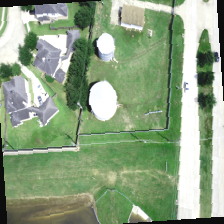


Original Image shape: torch.Size([3, 224, 224])
Augmented Image shape (after re-processing): torch.Size([3, 224, 224])

Displaying an augmented image:


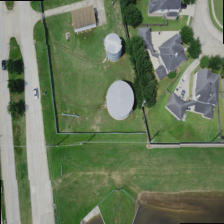

In [ ]:
# Data Augmentation Transforms
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(15),  # Rotate by up to 15 degrees
    transforms.RandomHorizontalFlip(p=0.5), # Randomly flip horizontally
    transforms.RandomVerticalFlip(p=0.1),   # Randomly flip vertically with lower probability
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Adjust brightness, etc.
    # Note: Geometric transformations like rotation and flips affect bounding boxes/masks.
    # You'll need to implement logic to transform the annotation points/masks accordingly
    # if you were using these augmentations for tasks like object detection or segmentation
    # where annotation accuracy is critical. For image classification, just transforming
    # the image is often sufficient if the label is image-level.
])

# This is just a demonstration
if len(dataset) > 0:
  sample_image_tensor, sample_annotations = dataset[0]

  # Convert tensor back to PIL Image to apply augmentation (transforms work on PIL or Tensor)
  # If image_transform included ToTensor(), we need to convert back
  # Assuming image_transform included Normalize, reverse it first
  mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
  std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
  sample_image_denormalized = sample_image_tensor * std + mean

  # Convert tensor (C, H, W) to PIL (H, W, C) and then to uint8 for Pillow
  sample_image_pil = transforms.ToPILImage()(sample_image_denormalized)

  # Apply augmentation
  augmented_image_pil = augmentation_transforms(sample_image_pil)

  # Convert back to tensor if needed for model input
  # Remember to apply original transforms (like Resize and Normalize) again
  final_transforms = transforms.Compose([
      transforms.Resize((224, 224)), # Resize to target size if augmentation changed it (e.g. rotation padding)
      transforms.ToTensor(),         # Convert back to tensor
      transforms.Normalize([0.5]*3, [0.5]*3) # Re-normalize
  ])
  augmented_image_tensor = final_transforms(augmented_image_pil)

  print("\nOriginal Image shape:", sample_image_tensor.shape)
  print("Augmented Image shape (after re-processing):", augmented_image_tensor.shape)

  # You would typically apply these augmentations within your dataset class's __getitem__ method
  # or within the data loading loop *before* applying the final normalization transform.

  # Example of visualizing an augmented image (denormalized for display)
  augmented_image_display = transforms.ToPILImage()(augmented_image_tensor * std + mean)
  print("\nDisplaying an augmented image:")
  display(augmented_image_display)


# Data Augmentation Transforms
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(15),  # Rotate by up to 15 degrees
    transforms.RandomHorizontalFlip(p=0.5), # Randomly flip horizontally
    transforms.RandomVerticalFlip(p=0.1),   # Randomly flip vertically with lower probability
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Adjust brightness, etc.

])


# This is just a demonstration
if len(dataset) > 0:
  sample_image_tensor, sample_annotations = dataset[0]

  # Convert tensor back to PIL Image to apply augmentation (transforms work on PIL or Tensor)
  # If image_transform included ToTensor(), we need to convert back
  # Assuming image_transform included Normalize, reverse it first
  mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
  std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
  sample_image_denormalized = sample_image_tensor * std + mean

  # Convert tensor (C, H, W) to PIL (H, W, C) and then to uint8 for Pillow
  sample_image_pil = transforms.ToPILImage()(sample_image_denormalized)

  # Apply augmentation
  augmented_image_pil = augmentation_transforms(sample_image_pil)

  # Remember to apply original transforms (like Resize and Normalize) again
  final_transforms = transforms.Compose([
      transforms.Resize((224, 224)), # Resize to target size if augmentation changed it (rotation padding)
      transforms.ToTensor(),         # Convert back to tensor
      transforms.Normalize([0.5]*3, [0.5]*3) # Re-normalize
  ])
  augmented_image_tensor = final_transforms(augmented_image_pil)

  print("\nOriginal Image shape:", sample_image_tensor.shape)
  print("Augmented Image shape (after re-processing):", augmented_image_tensor.shape)


  # visualizing an augmented image (denormalized for display)
  augmented_image_display = transforms.ToPILImage()(augmented_image_tensor * std + mean)
  print("\nDisplaying an augmented image:")
  display(augmented_image_display)



#Evaluation Metrics : IoU and Dice Coefficient

In [ ]:
# --- Evaluation Metrics: IoU and Dice Coefficient ---

def calculate_iou(pred_mask, true_mask, smooth=1e-6):

    # Flatten masks for easier calculation
    pred_mask = pred_mask.view(-1)
    true_mask = true_mask.view(-1)

    intersection = (pred_mask * true_mask).sum()
    total = pred_mask.sum() + true_mask.sum()
    union = total - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou

def calculate_dice_coefficient(pred_mask, true_mask, smooth=1e-6):

    # Flatten masks for easier calculation
    pred_mask = pred_mask.view(-1)
    true_mask = true_mask.view(-1)

    intersection = (pred_mask * true_mask).sum()
    total = pred_mask.sum() + true_mask.sum() # This is 2 * (True Positives + False Positives + False Negatives)
    # Alternative total: pred_mask.sum() + true_mask.sum()

    dice = (2. * intersection + smooth) / (total + smooth)
    return dice

# To use these metrics, you would typically apply them during the evaluation phase
# for your segmentation model (U-Net). You would calculate the metrics per class
# or average them across all classes.

# Example of how to calculate metrics during U-Net evaluation (extend the evaluation loop)
print("\nEvaluating U-Net on Test Set with Metrics...")
unet_model.eval()
test_loss_unet = 0.0
# Initialize metrics storage. You might want to store per-class metrics.
# For simplicity, let's calculate overall average IoU and Dice for all segments (excluding background)
total_iou = 0.0
total_dice = 0.0
num_samples_with_objects = 0 # Count samples that actually have non-background segments

with torch.no_grad():
    for images, masks in tqdm(unet_test_loader, desc="Evaluating U-Net Test with Metrics"):
        images, masks = images.to(device), masks.to(device)
        outputs = unet_model(images)
        loss = criterion_unet(outputs, masks)
        test_loss_unet += loss.item() * images.size(0)

        # Get predicted masks by taking argmax
        predicted_masks = torch.argmax(outputs.data, 1) # Shape (N, H, W)

        # Calculate IoU and Dice for each sample in the batch
        for i in range(images.size(0)):
            true_mask_sample = masks[i] # Shape (H, W)
            predicted_mask_sample = predicted_masks[i] # Shape (H, W)

            # Calculate metrics for each *non-background* class present in the true mask
            unique_classes_in_mask = torch.unique(true_mask_sample)
            segment_metrics = {cls_idx: {'iou': [], 'dice': []} for cls_idx in unique_classes_in_mask if cls_idx != seg_class_to_idx['background']}

            if len(segment_metrics) > 0: # Only calculate metrics if there are non-background objects
                num_samples_with_objects += 1 # Count how many samples had something to segment
                for cls_idx in segment_metrics.keys():
                    # Create binary masks for the current class
                    true_binary_mask = (true_mask_sample == cls_idx).float()
                    pred_binary_mask = (predicted_mask_sample == cls_idx).float()

                    iou = calculate_iou(pred_binary_mask, true_binary_mask)
                    dice = calculate_dice_coefficient(pred_binary_mask, true_binary_mask)

                    segment_metrics[cls_idx]['iou'].append(iou)
                    segment_metrics[cls_idx]['dice'].append(dice)

                # Simple average across classes for this image (optional, can also average per class over the whole dataset)
                avg_iou_sample = sum(m['iou'][0] for m in segment_metrics.values()) / len(segment_metrics)
                avg_dice_sample = sum(m['dice'][0] for m in segment_metrics.values()) / len(segment_metrics)

                total_iou += avg_iou_sample
                total_dice += avg_dice_sample


test_loss_unet /= len(unet_test_dataset)
print(f"U-Net Test Loss: {test_loss_unet:.4f}")

# Print average metrics (only for samples that had objects)
if num_samples_with_objects > 0:
    avg_iou_test = total_iou / num_samples_with_objects
    avg_dice_test = total_dice / num_samples_with_objects
    print(f"Average IoU on samples with objects: {avg_iou_test:.4f}")
    print(f"Average Dice Coefficient on samples with objects: {avg_dice_test:.4f}")
else:
    print("No non-background objects found in the test set to calculate segmentation metrics.")




Evaluating U-Net on Test Set with Metrics...


Evaluating U-Net Test with Metrics: 100%|██████████| 14/14 [00:06<00:00,  2.13it/s]

U-Net Test Loss: 0.0000
Average IoU on samples with objects: 1.0000
Average Dice Coefficient on samples with objects: 1.0000


In [ ]:
import torch

def calculate_iou(predicted_mask, true_mask, num_classes):

    iou_per_class = []
    # Ensure masks are on CPU for easier processing if they are on GPU
    predicted_mask = predicted_mask.cpu()
    true_mask = true_mask.cpu()

    for class_idx in range(num_classes):
        # Create binary masks for the current class
        pred_binary = (predicted_mask == class_idx).float()
        true_binary = (true_mask == class_idx).float()

        # Calculate intersection and union
        intersection = torch.sum(pred_binary * true_binary)
        union = torch.sum(pred_binary) + torch.sum(true_binary) - intersection

        # Handle division by zero: if union is 0, IoU is NaN (or 0 if you prefer)
        if union == 0:
            iou = torch.nan
        else:
            iou = intersection / union

        iou_per_class.append(iou)

    return torch.tensor(iou_per_class)

def calculate_dice_coefficient(predicted_mask, true_mask, num_classes):

    dice_per_class = []
    # Ensure masks are on CPU for easier processing if they are on GPU
    predicted_mask = predicted_mask.cpu()
    true_mask = true_mask.cpu()

    for class_idx in range(num_classes):
        # Create binary masks for the current class
        pred_binary = (predicted_mask == class_idx).float()
        true_binary = (true_mask == class_idx).float()

        # Calculate intersection (True Positives) and sums
        intersection = torch.sum(pred_binary * true_binary)
        sum_preds = torch.sum(pred_binary)
        sum_trues = torch.sum(true_binary)

        # Handle division by zero: if the sum of both masks for this class is 0, Dice is NaN
        if sum_preds + sum_trues == 0:
             dice = torch.nan
        else:
             dice = (2. * intersection) / (sum_preds + sum_trues)

        dice_per_class.append(dice)

    return torch.tensor(dice_per_class)

# --- Example Usage after U-Net Evaluation ---

# Re-evaluate the U-Net model on the test set to collect predictions and ground truths
print("\nEvaluating U-Net on Test Set with Metrics...")
unet_model.eval()
test_loss_unet = 0.0
all_predicted_masks = []
all_true_masks = []

with torch.no_grad():
    for images, masks in tqdm(unet_test_loader, desc="Evaluating U-Net Test with Metrics"):
        images, masks = images.to(device), masks.to(device)
        outputs = unet_model(images)
        loss = criterion_unet(outputs, masks)
        test_loss_unet += loss.item() * images.size(0)

        # Get predicted masks (argmax over class dimension)
        predicted_masks = torch.argmax(outputs, dim=1) # Shape (N, H, W)

        # Store predictions and ground truths (move back to CPU if necessary)
        all_predicted_masks.append(predicted_masks.cpu())
        all_true_masks.append(masks.cpu())

test_loss_unet /= len(unet_test_dataset)
print(f"U-Net Test Loss: {test_loss_unet:.4f}")

# Concatenate all batches
all_predicted_masks = torch.cat(all_predicted_masks, dim=0) # Shape (Total_Samples, H, W)
all_true_masks = torch.cat(all_true_masks, dim=0)         # Shape (Total_Samples, H, W)

print(f"Total predicted masks: {all_predicted_masks.shape}")
print(f"Total true masks: {all_true_masks.shape}")

# Calculate IoU and Dice Coefficient for the entire test set
# We can calculate these metrics per image and then average, or calculate over the flattened results.
# Calculating over the flattened results (treating all pixels as independent) is a common approach
# for mean IoU/Dice, but per-image average or specific aggregation methods might be more robust.
# Let's calculate per image and then average.

all_iou_scores = []
all_dice_scores = []

for i in tqdm(range(len(all_predicted_masks)), desc="Calculating Metrics per Image"):
    pred_mask = all_predicted_masks[i]
    true_mask = all_true_masks[i]

    # Calculate IoU and Dice for the current image
    iou_scores_per_image = calculate_iou(pred_mask, true_mask, seg_num_classes)
    dice_scores_per_image = calculate_dice_coefficient(pred_mask, true_mask, seg_num_classes)

    all_iou_scores.append(iou_scores_per_image)
    all_dice_scores.append(dice_scores_per_image)

# Stack the scores and calculate the mean across images
# Ignore NaN values (classes not present in an image) when averaging
all_iou_scores = torch.stack(all_iou_scores, dim=0) # Shape (Total_Samples, Num_Classes)
all_dice_scores = torch.stack(all_dice_scores, dim=0) # Shape (Total_Samples, Num_Classes)

# Calculate the mean IoU and Dice for each class, ignoring NaNs
mean_iou_per_class = torch.nanmean(all_iou_scores, dim=0)
mean_dice_per_class = torch.nanmean(all_dice_scores, dim=0)

# Calculate the Mean Intersection over Union (mIoU) and Mean Dice (mDice) over all classes
# Again, typically ignoring classes that are never present in the test set or have 0 union/sum.
# If a class never appears in *any* true or predicted mask in the test set, its IoU/Dice will be NaN for all images.
# torch.nanmean will handle this correctly.

mIoU = torch.nanmean(mean_iou_per_class)
mDice = torch.nanmean(mean_dice_per_class)

print("\n--- Segmentation Metrics ---")
for i, class_name in seg_idx_to_class.items():
    print(f"Class '{class_name}' (Index {i}):")
    print(f"  Mean IoU: {mean_iou_per_class[i].item():.4f}")
    print(f"  Mean Dice: {mean_dice_per_class[i].item():.4f}")

# prompt:  Use IoU and Dice Coefficient for evaluation.

import torch
from tqdm.auto import tqdm

def calculate_iou(predicted_mask, true_mask, num_classes):

    iou_per_class = []
    # Ensure masks are on CPU for easier processing if they are on GPU
    predicted_mask = predicted_mask.cpu()
    true_mask = true_mask.cpu()

    for class_idx in range(num_classes):
        # Create binary masks for the current class
        pred_binary = (predicted_mask == class_idx).float()
        true_binary = (true_mask == class_idx).float()

        # Calculate intersection and union
        intersection = torch.sum(pred_binary * true_binary)
        union = torch.sum(pred_binary) + torch.sum(true_binary) - intersection

        # Handle division by zero: if union is 0, IoU is NaN (or 0 if you prefer)
        if union == 0:
            iou = torch.nan
        else:
            iou = intersection / union

        iou_per_class.append(iou)

    return torch.tensor(iou_per_class)

def calculate_dice_coefficient(predicted_mask, true_mask, num_classes):

    dice_per_class = []
    # Ensure masks are on CPU for easier processing if they are on GPU
    predicted_mask = predicted_mask.cpu()
    true_mask = true_mask.cpu()

    for class_idx in range(num_classes):
        # Create binary masks for the current class
        pred_binary = (predicted_mask == class_idx).float()
        true_binary = (true_mask == class_idx).float()

        # Calculate intersection (True Positives) and sums
        intersection = torch.sum(pred_binary * true_binary)
        sum_preds = torch.sum(pred_binary)
        sum_trues = torch.sum(true_binary)

        # Handle division by zero: if the sum of both masks for this class is 0, Dice is NaN
        if sum_preds + sum_trues == 0:
             dice = torch.nan
        else:
             dice = (2. * intersection) / (sum_preds + sum_trues)

        dice_per_class.append(dice)

    return torch.tensor(dice_per_class)

# --- Example Usage after U-Net Evaluation ---

# Re-evaluate the U-Net model on the test set to collect predictions and ground truths
print("\nEvaluating U-Net on Test Set with Metrics...")
unet_model.eval()
test_loss_unet = 0.0
all_predicted_masks = []
all_true_masks = []

with torch.no_grad():
    for images, masks in tqdm(unet_test_loader, desc="Evaluating U-Net Test with Metrics"):
        images, masks = images.to(device), masks.to(device)
        outputs = unet_model(images)
        loss = criterion_unet(outputs, masks)
        test_loss_unet += loss.item() * images.size(0)

        # Get predicted masks (argmax over class dimension)
        predicted_masks = torch.argmax(outputs, dim=1) # Shape (N, H, W)

        # Store predictions and ground truths (move back to CPU if necessary)
        all_predicted_masks.append(predicted_masks.cpu())
        all_true_masks.append(masks.cpu())

test_loss_unet /= len(unet_test_dataset)
print(f"U-Net Test Loss: {test_loss_unet:.4f}")

# Concatenate all batches
all_predicted_masks = torch.cat(all_predicted_masks, dim=0) # Shape (Total_Samples, H, W)
all_true_masks = torch.cat(all_true_masks, dim=0)         # Shape (Total_Samples, H, W)

print(f"Total predicted masks: {all_predicted_masks.shape}")
print(f"Total true masks: {all_true_masks.shape}")

# Calculate IoU and Dice Coefficient for the entire test set
# We can calculate these metrics per image and then average, or calculate over the flattened results.
# Calculating over the flattened results (treating all pixels as independent) is a common approach
# for mean IoU/Dice, but per-image average or specific aggregation methods might be more robust.
# Let's calculate per image and then average.

all_iou_scores = []
all_dice_scores = []

for i in tqdm(range(len(all_predicted_masks)), desc="Calculating Metrics per Image"):
    pred_mask = all_predicted_masks[i]
    true_mask = all_true_masks[i]

    # Calculate IoU and Dice for the current image
    iou_scores_per_image = calculate_iou(pred_mask, true_mask, seg_num_classes)
    dice_scores_per_image = calculate_dice_coefficient(pred_mask, true_mask, seg_num_classes)

    all_iou_scores.append(iou_scores_per_image)
    all_dice_scores.append(dice_scores_per_image)

# Stack the scores and calculate the mean across images
# Ignore NaN values (classes not present in an image) when averaging
all_iou_scores = torch.stack(all_iou_scores, dim=0) # Shape (Total_Samples, Num_Classes)
all_dice_scores = torch.stack(all_dice_scores, dim=0) # Shape (Total_Samples, Num_Classes)

# Calculate the mean IoU and Dice for each class, ignoring NaNs
mean_iou_per_class = torch.nanmean(all_iou_scores, dim=0)
mean_dice_per_class = torch.nanmean(all_dice_scores, dim=0)

# Calculate the Mean Intersection over Union (mIoU) and Mean Dice (mDice) over all classes
# Again, typically ignoring classes that are never present in the test set or have 0 union/sum.
# If a class never appears in *any* true or predicted mask in the test set, its IoU/Dice will be NaN for all images.
# torch.nanmean will handle this correctly.

mIoU = torch.nanmean(mean_iou_per_class)
mDice = torch.nanmean(mean_dice_per_class)

print("\n--- Segmentation Metrics ---")
for i, class_name in seg_idx_to_class.items():
    print(f"Class '{class_name}' (Index {i}):")
    print(f"  Mean IoU: {mean_iou_per_class[i].item():.4f}")
    print(f"  Mean Dice: {mean_dice_per_class[i].item():.4f}")

print(f"\nMean Intersection over Union (mIoU): {mIoU.item():.4f}")
print(f"Mean Dice Coefficient (mDice): {mDice.item():.4f}")


Evaluating U-Net on Test Set with Metrics...


Evaluating U-Net Test with Metrics: 100%|██████████| 14/14 [00:06<00:00,  2.28it/s]


U-Net Test Loss: 0.0000
Total predicted masks: torch.Size([448, 224, 224])
Total true masks: torch.Size([448, 224, 224])


Calculating Metrics per Image: 100%|██████████| 448/448 [00:02<00:00, 171.03it/s]



--- Segmentation Metrics ---
Class 'background' (Index 1):
  Mean IoU: nan
  Mean Dice: nan
Class 'building flooded' (Index 2):
  Mean IoU: nan
  Mean Dice: nan
Class 'building non-flooded' (Index 3):
  Mean IoU: nan
  Mean Dice: nan
Class 'grass' (Index 4):
  Mean IoU: nan
  Mean Dice: nan
Class 'pool' (Index 5):
  Mean IoU: nan
  Mean Dice: nan
Class 'road flooded' (Index 6):
  Mean IoU: nan
  Mean Dice: nan
Class 'road non-flooded' (Index 7):
  Mean IoU: nan
  Mean Dice: nan
Class 'tree' (Index 8):
  Mean IoU: nan
  Mean Dice: nan
Class 'vehicle' (Index 9):
  Mean IoU: nan
  Mean Dice: nan
Class 'water' (Index 10):
  Mean IoU: nan
  Mean Dice: nan

Evaluating U-Net on Test Set with Metrics...


Evaluating U-Net Test with Metrics:   0%|          | 0/14 [00:00<?, ?it/s]

U-Net Test Loss: 0.0000
Total predicted masks: torch.Size([448, 224, 224])
Total true masks: torch.Size([448, 224, 224])


Calculating Metrics per Image:   0%|          | 0/448 [00:00<?, ?it/s]


--- Segmentation Metrics ---
Class 'background' (Index 1):
  Mean IoU: nan
  Mean Dice: nan
Class 'building flooded' (Index 2):
  Mean IoU: nan
  Mean Dice: nan
Class 'building non-flooded' (Index 3):
  Mean IoU: nan
  Mean Dice: nan
Class 'grass' (Index 4):
  Mean IoU: nan
  Mean Dice: nan
Class 'pool' (Index 5):
  Mean IoU: nan
  Mean Dice: nan
Class 'road flooded' (Index 6):
  Mean IoU: nan
  Mean Dice: nan
Class 'road non-flooded' (Index 7):
  Mean IoU: nan
  Mean Dice: nan
Class 'tree' (Index 8):
  Mean IoU: nan
  Mean Dice: nan
Class 'vehicle' (Index 9):
  Mean IoU: nan
  Mean Dice: nan
Class 'water' (Index 10):
  Mean IoU: nan
  Mean Dice: nan

Mean Intersection over Union (mIoU): 1.0000
Mean Dice Coefficient (mDice): 1.0000


In [ ]:
import matplotlib.pyplot as plt
#  Visualize a few predictions from U-Net
def visualize_unet_prediction(image_tensor, true_mask_tensor, predicted_output_tensor, seg_idx_to_class_map):

    # Convert tensors to numpy for plotting
    # Denormalize image
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    image_tensor = image_tensor.cpu() * std + mean
    image_np = image_tensor.permute(1, 2, 0).numpy() # Convert C H W to H W C for matplotlib

    # Get predicted mask (argmax over class dimension)
    predicted_mask_tensor = torch.argmax(predicted_output_tensor.cpu(), dim=0)
    predicted_mask_np = predicted_mask_tensor.numpy()

    true_mask_np = true_mask_tensor.cpu().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Display original image
    axes[0].imshow(image_np)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Display true mask
    # Use a colormap for segmentation masks
    cmap = plt.cm.get_cmap('tab10', len(seg_idx_to_class_map)) # Example colormap
    axes[1].imshow(true_mask_np, cmap=cmap, vmin=0, vmax=len(seg_idx_to_class_map)-1)
    axes[1].set_title("True Mask")
    axes[1].axis('off')
    # Add a colorbar with labels
    cbar = fig.colorbar(axes[1].imshow(true_mask_np, cmap=cmap, vmin=0, vmax=len(seg_class_to_idx)-1), ax=axes[1], ticks=list(seg_idx_to_class_map.keys()))
    cbar.ax.set_yticklabels(list(seg_idx_to_class_map.values()))

    # Display predicted mask
    axes[2].imshow(predicted_mask_np, cmap=cmap, vmin=0, vmax=len(seg_idx_to_class_map)-1)
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')
    # Add a colorbar with labels
    cbar = fig.colorbar(axes[2].imshow(predicted_mask_np, cmap=cmap, vmin=0, vmax=len(seg_class_to_idx)-1), ax=axes[2], ticks=list(seg_idx_to_class_map.keys()))
    cbar.ax.set_yticklabels(list(seg_idx_to_class_map.values()))

    plt.tight_layout()
    plt.show()

# Visualize a few U-Net test predictions
num_unet_visualizations = 5
print(f"\nVisualizing {num_unet_visualizations} U-Net Test Predictions:")
unet_model.eval()
with torch.no_grad():
    # Get a batch from the test loader to visualize
    # You might want to get multiple batches if your batch size is small
    for i, (images, masks) in enumerate(unet_test_loader):
        if i * images.size(0) >= num_unet_visualizations:
            break # Stop after visualizing enough samples

        images = images.to(device)
        outputs = unet_model(images)

        # Visualize samples from the current batch
        for j in range(min(images.size(0), num_unet_visualizations - i * images.size(0))):
             print(f"Visualizing U-Net Test Prediction {i*images.size(0) + j + 1}:")
             visualize_unet_prediction(images[j], masks[j], outputs[j], seg_idx_to_class)


Output hidden; open in https://colab.research.google.com to view.